#### Importing Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import random
from skimage import io, transform, exposure
from skimage.transform import ProjectiveTransform, rotate, warp

In [2]:
def save_data(datafile, data):
    with open(datafile, 'wb') as file:
        pickle.dump(data, file)

def load_data(datafile):
    with open(datafile, 'rb') as file:
        return pickle.load(file)

In [3]:
#Loading Training Data
base_dir = os.path.join(os.getcwd(), 'Training_Images')
train_data = {i : [] for i in range(len(os.listdir(base_dir)))}
for i, folder in zip(train_data, os.listdir(base_dir)):
    folder_path = os.path.join(base_dir, folder)
    for file in os.listdir(folder_path):
        if file.endswith('ppm'):
            file_path = os.path.join(folder_path, file)
            image = np.array(io.imread(file_path))
            image = transform.resize(image, (32, 32), mode='edge')
            train_data[i].append(image)

In [4]:
#Load Test Data
df =  pd.read_csv('Test.csv')
test_data = {
    'feature' : [],
    'label' : []
}

base_dir = os.path.join(os.getcwd(), 'Test_Images')
for i, images in enumerate(os.listdir(base_dir)):
    if images.endswith('ppm'):
        images = os.path.join(base_dir, images)
        images = np.array(io.imread(images))
        images = transform.resize(images, (32, 32), mode ='edge')
        test_data['feature'].append(images)
        test_data['label'].append(df['ClassId'][i])

### The German Traffic Sign Recogniton Bencmark

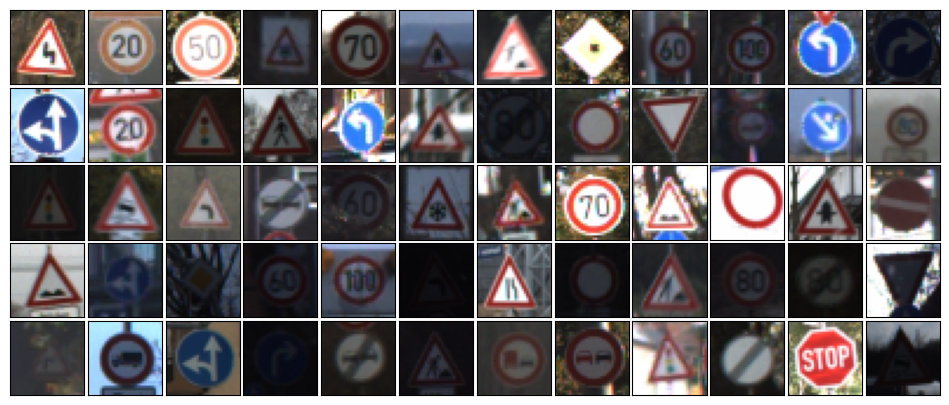

In [4]:

fig, axs = plt.subplots(5, 12, figsize=(12, 5), gridspec_kw={'hspace':0.05, 'wspace': 0.05})
for i in range(5):
    classes = random.sample(range(0, 42), 12)
    for j in range(12):
        axs[i, j].imshow(train_data[classes[j]][random.randint(0, len(train_data[classes[j]]) - 1)])
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
plt.show()

The dataset comprises 43 distinct classes, each representing a unique category. Upon analyzing the dataset distribution, I observed that the number of samples varies significantly across the classes, indicating an imbalance. Some classes are well-represented with a large number of samples, while others have relatively few, potentially impacting the performance of models trained on this data due to biased learning towards the overrepresented classes.

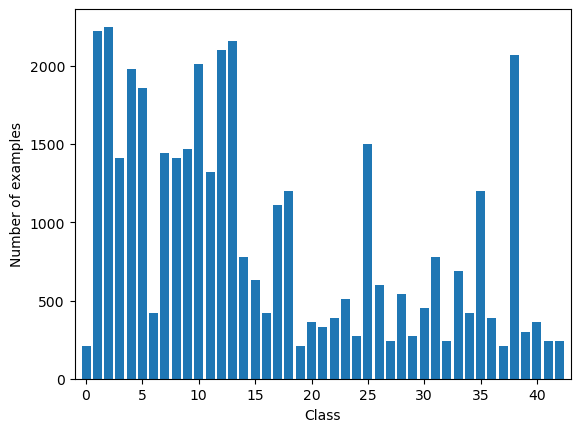

In [7]:

plt.bar(np.arange(43), [len(train_data[i]) for i in range(43)], align='center')
plt.xlabel('Class')
plt.ylabel('Number of examples')
plt.xlim([-1, 43])
plt.show()

## Image Augmentation

The dataset contains a total of 39,209 training examples, which may be insufficient for the model to generalize effectively. To address this limitation, data augmentation techniques were applied, specifically image flipping, rotate and warping to expand the dataset while preserving class labels.

In [8]:
#Data Functions
def image_flip(feature, label):
    vert = [1, 5, 12, 15, 17]
    hori = [11, 12, 13, 15, 17, 18, 22, 26, 30, 35]
    both = [32, 40]
    chng = {19: 20, 20: 19,
            33: 34, 34: 33,
            36: 37, 37: 36,
            38: 39, 39: 38}

    if label in vert:
        vert_flipped = np.flip(feature, axis=0)
        return vert_flipped, label
    
    if label in hori:
        hori_flipped = np.flip(feature, axis=1)
        return hori_flipped, label
    
    if label in both:
        new_image = np.flip(feature, axis=(0, 1))
        return new_image, label
    
    if label in chng:
        flipped_image = np.flip(feature, axis=1)
        return flipped_image, chng[label]
    

def image_warp(feature, label=None, intensity=0.75):
    delta = 32 * .3 * intensity
    tl_top = random.uniform(-delta, delta)
    tl_left = random.uniform(-delta, delta)
    bl_bot = random.uniform(-delta, delta)
    bl_left = random.uniform(-delta, delta)
    tr_top = random.uniform(-delta, delta)
    tr_right = random.uniform(-delta, delta)
    br_bot = random.uniform(-delta, delta)
    br_right = random.uniform(-delta, delta)

    tf = ProjectiveTransform()
    tf.estimate(np.array(((tl_left, tl_top), 
                          (bl_left, 32 - bl_bot), 
                          (32 - br_right, 32 - br_bot), 
                          (32 - tr_right, tr_top))),
                np.array(((0, 0),
                          (0, 32),
                          (32, 32),
                          (32, 0)))
                )

    new_image = transform.warp(feature, tf, order=1, mode='edge')
    return new_image, label

def image_rotate(feature, label=None, intensity=0.75):
    delta = 30 * intensity
    new_image = transform.rotate(feature, angle=(random.uniform(-delta, delta)), mode='edge')
    return new_image, label

def grayscale_contrast(feature):
    new_image = 0.2989 * feature[:, :, 0] + 0.5870 * feature[:, :, 1] + 0.1140 * feature[:, :, 2]
    new_image = exposure.equalize_adapthist(new_image)
    return new_image



#### Image Flip

Certain images exhibit vertical or horizontal symmetry, enabling us to flip them while retaining their original class. For instance:

*   <b>Flip Vertically</b>: Speed Limit 30kph
*   <b>Flip Horizontally</b>: Right of way at the next intersection

Some images can be flipped both vertically and horizontally without altering their classification. 
For example:

*   <b>Flip both:</b> End of all speed and passing limits

Additionally, there are pairs of images where flipping horizontally changes the classification. This occurs because the flipped version corresponds to a different class. 
For example:

*   <b>Flip then change class</b>: Dangerous curve to the left -> Dangerous curve to the right (vise versa)

Through this augmentation process, the dataset size increased significantly, from <b>39,209</b> examples to <b>63,538</b>, improving the diversity and representation of the data and potentially enhancing the model’s ability to generalize

----------------------------------------------------------
Flip Vertical (Before(top), After(bottom))
----------------------------------------------------------


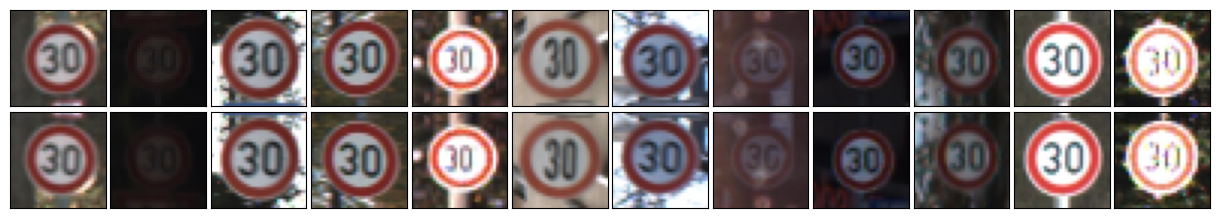

----------------------------------------------------------
Flip Horizontal (Before(top), After(bottom))
----------------------------------------------------------


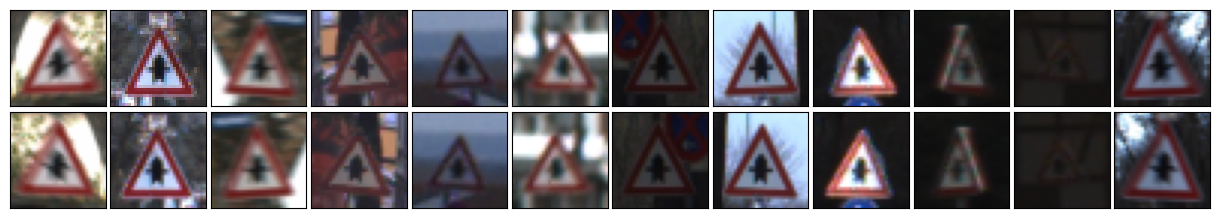

----------------------------------------------------------
Flip Both (Before(top), After(bottom))
----------------------------------------------------------


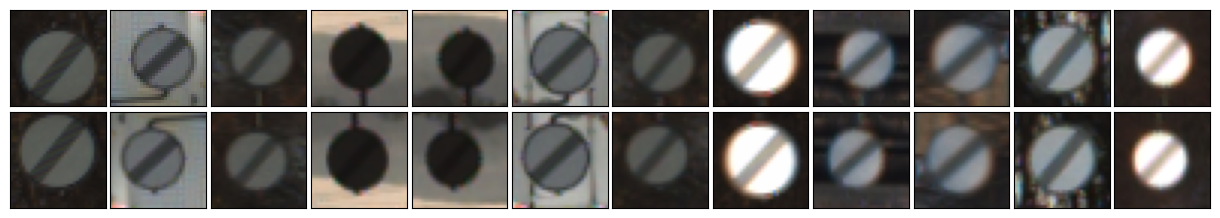

----------------------------------------------------------
Flip to other class (Before(top), After(bottom))
----------------------------------------------------------


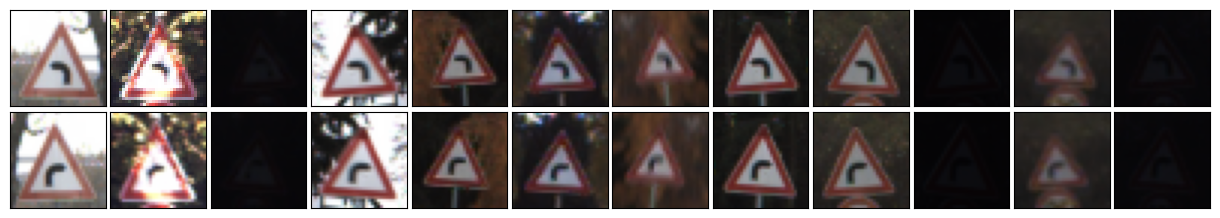

In [9]:

flipp = ['Flip Vertical', 'Flip Horizontal', 'Flip Both', 'Flip to other class']
classes = [1, 11, 32, 19]

for i in range(len(flipp)):
    print(f'----------------------------------------------------------')
    print(f'{flipp[i]} (Before(top), After(bottom))')
    print(f'----------------------------------------------------------')
    fig = plt.figure(figsize=(12, 2))
    fig.subplots_adjust(left=0, right=1, top=(1), bottom=(0), hspace=0.05, wspace=0.05)
    sample = random.sample(range(0, len(train_data[classes[i]]) - 1), 12)
    for  j in range(12):
        axs1 = fig.add_subplot(2, 12, j + 1, xticks=[], yticks=[])
        axs2 = fig.add_subplot(2, 12, j + 13, xticks=[], yticks=[])
        image = train_data[classes[i]][sample[j]]
        flip = image_flip(image, classes[i])
        axs1.imshow(image)
        axs2.imshow(flip[0])
    plt.show()

#### Image Rotate + Warp

The dataset, even after augmentation, remains imbalanced, and the expanded size of 63,538 examples is still insufficient for the model to generalize effectively. To further address these challenges, additional data augmentation techniques were applied, specifically random rotation.

To preserve the image's core features while introducing variation, images were randomly rotated by small angles. Each rotated image was then applied slight distortions and appended to the corresponding class set. This helped expand the dataset by introducing diverse variations of existing samples without compromising their integrity.

To tackle class imbalance, class with the maximum example was identified. For other classes, images were repeatedly rotated and augmented until their quantity matched the maximum class size. This ensured that all classes were equally represented, effectively balancing the dataset.

By using these methods, the dataset was expanded and balanced, increasing its diversity and improving the likelihood of the model generalizing well during training.

----------------------------------------------------------
Rotate + Warped (Before(top), After(bottom))
----------------------------------------------------------


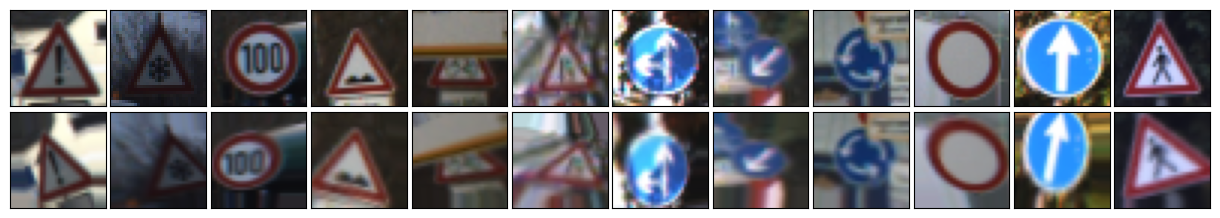

In [10]:

print(f'----------------------------------------------------------')
print(f'Rotate + Warped (Before(top), After(bottom))')
print(f'----------------------------------------------------------')
fig = plt.figure(figsize=(12, 2))
fig.subplots_adjust(left=0, right=1, top=(1), bottom=(0), hspace=0.05, wspace=0.05)
sample = random.sample(range(0, 42), 12)
for i in range(12):
    axs1 = fig.add_subplot(2, 12, i + 1, xticks=[], yticks=[])
    axs2 = fig.add_subplot(2, 12, i + 13, xticks=[], yticks=[])
    image = train_data[sample[i]][random.randint(0, len(train_data[sample[i]]) - 1)]
    rotate, _ = image_rotate(image)
    augmented, _ = image_warp(rotate)
    axs1.imshow(image)
    axs2.imshow(augmented)
plt.show()

In [1]:

print(f'----------------------------------------------------------')
print(f'Grayscaled + Adjust Contrast (Before(top), After(bottom))')
print(f'----------------------------------------------------------')
fig = plt.figure(figsize=(12, 2))
fig.subplots_adjust(left=0, right=1, top=(1), bottom=(0), hspace=0.05, wspace=0.05)
sample = random.sample(range(0, 42), 12)
for i in range(12):
    axs1 = fig.add_subplot(2, 12, i + 1, xticks=[], yticks=[])
    axs2 = fig.add_subplot(2, 12, i + 13, xticks=[], yticks=[])
    image = train_data[sample[i]][random.randint(0, len(train_data[sample[i]]) - 1)]
    gray = grayscale_contrast(image)
    axs1.imshow(image)
    axs2.imshow(gray, cmap=plt.cm.gray)
plt.show()

----------------------------------------------------------
Grayscaled + Adjust Contrast (Before(top), After(bottom))
----------------------------------------------------------


NameError: name 'plt' is not defined

In [ ]:
#Flip Images
dump = [[] for _ in range(len(train_data))]

for i, feature in train_data.items():
    for image in feature:
        for feat, labl in image_flip(image, i):
            dump[labl].append(feat)

for i in range(len(dump)):
    train_data[i] += dump[i]

In [ ]:
#Warp Images
temp = {i : value[:] for i, value in train_data.items()}
max_sample = max([len(temp[i]) for i in range(len(temp))])

for label, feature in train_data.items():
    while len(feature) < max_sample:
        aug_image, lbl = image_rotate(feature[random.randint(0, len(temp[label]) - 1)], label)
        aug_image, lbl = image_warp(aug_image, lbl)
        train_data[lbl].append(aug_image)

In [ ]:
#Store Data into single list
final_train = {
    'feature': [],
    'label': []
}

for lbl, fet in train_data.items():
    for f in fet:
        final_train['feature'].append(grayscale_contrast(f))
        final_train['label'].append(lbl)

final_train['feature'] = np.stack(final_train['feature'])
final_train['label'] = np.stack(final_train['label'])

In [11]:

final_test = {
    'feature': [],
    'label' : []
}

for fet, lbl in zip(test_data['feature'], test_data['label']):
    final_test['feature'].append(grayscale_contrast(fet))
    final_test['label'].append(lbl)

final_test['feature'] = np.stack(final_test['feature'])
final_test['label'] = np.stack(final_test['label'])

In [12]:
# Save Augmented data
save_data('training_data.pkl', final_train)
save_data('test_data.pkl', final_test)

In [7]:
# Load presaved augmented data
train_data = load_data('training_data.pkl') 
test_data = load_data('test_data.pkl')

# Model Design

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
from torch.utils.data import DataLoader, TensorDataset
from torchvision import io, transforms

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
#Initial Hyperparameters
num_epochs = 50
batch_size = 100
learning_rate = 1e-4

In [11]:
data_transform = transforms.Normalize(mean=[0.5], std=[1])

In [12]:
class TrafficCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv32 = nn.Conv2d(1, 32, 5, padding=2) 
        self.dp32 = nn.Dropout(0.1)
        self.conv16 = nn.Conv2d(32, 64, 5, padding=2) 
        self.dp64 = nn.Dropout(0.2)
        self.conv8 = nn.Conv2d(64, 128, 5, padding=2)
        self.dp128 = nn.Dropout(0.3)
        self.maxp = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 1024)
        self.dp1024 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 43)

    def forward(self, x):
        # Conv -> ReLU -> MaxPool -> Conv -> ReLU -> MaxPool -> Conv -> ReLU -> Maxpool
        x = F.relu(self.conv32(x))
        x = self.maxp(self.dp32(x))
        x = F.relu(self.conv16(x))
        x = self.maxp(self.dp64(x))
        x = F.relu(self.conv8(x))
        x = self.maxp(self.dp128(x))
        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.dp1024(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [13]:
X_train = torch.from_numpy(train_data['feature']).unsqueeze(1)
X_train = data_transform(X_train)
y_train = torch.from_numpy(train_data['label'])

In [14]:
X_test = torch.from_numpy(test_data['feature']).unsqueeze(1)
X_test = data_transform(X_test)
y_test = torch.from_numpy(test_data['label'])

In [15]:
train_dataset = TensorDataset(X_train, y_train)
loaded_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
loaded_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [16]:
model = TrafficCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = opt.Adam(model.parameters(), lr=learning_rate)

In [ ]:
total_step = len(loaded_train)
for epoch in range(num_epochs):
    for i, (image, label) in enumerate(loaded_train):

        image = image.to(device)
        label = label.to(device)
        #Forward Pass
        out = model(image.float())

        try:
            loss = criterion(out, label.long())
        except Exception as e:
            print(f"Error in loss computation: {e}")
            continue

        #Backprop
        try:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        except Exception as e:
            print(f'Error in backpropagation: {e}')
            continue

        if (i+1) % 100 == 0:
            print(f'Epoch {epoch + 1}: Step [{(i+1) * 100}/{total_step * 100}] | Loss {loss.item():.4f} ')
            

print("Done Training")

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for data, label in loaded_test:
        data = data.to(device)
        label = label.to(device)

        out = model(data.float())
        _, pred = torch.max(out, 1)
        total += label.shape[0]
        correct += (pred == label).sum().item()

    acc = 100.0 * correct / total
    print(f'Accuracy = {acc:.2f}%')